In [45]:
# Initial imports
import os
from pathlib import Path
import requests
import csv
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
import datetime as dt
import locale


locale.setlocale( locale.LC_ALL, '' )
print(Path.cwd())

# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

def get_input_file_path():
    inputPath = input('Enter the path & file name that you wish to read from:')
    return inputPath

def get_data_table(data_path,index_column,csv=True,panda=True,api=None,jsonFlag=True,datetime_format=True,parse_dates=True,dateFormat=None,sort=True,dropNulls=True):
    if csv==True and panda!=True:
        with open(csvPath,'r') as csvFile:
            csvReader = csv.reader(csvFile,delimiter = ',')
            print(type(csvReader))
            #defining Parameters
            header = next(csvReader)
        return csvReader
    elif panda==True and api!=True:
        if csv==True:
            df = pd.read_csv(data_path, index_col=index_column, infer_datetime_format=datetime_format, parse_dates=parse_dates)
        if dateFormat != None:
            df.index = pd.to_datetime(df.index, format=dateFormat)
        if sort:
            df.sort_index(inplace=True)
        if dropNulls:
            df.dropna(inplace=True)
        return df
    elif api==True and panda!= True:
        if jsonFlag:
            data_path = data_path + "?format=json"
            data = requests.get(btc_url)
            data_table = data.json()
        else:
            data_table = requests.get(btc_url)
        
        return data_table
        
        
def setOutputPath():
    outputPath = input('Enter the path & file name that you wish to output to:')
    return outputPath

def writeCsvPath(outputPath,data=None,header=True):
    # Set the output header
    header = ["Net_Total","Number_of_Months","Min_Profit_Loss","Max_Profit_Loss","Average_Profit_Loss"]

    # Set the output file path
    output = Path(outputPath)

    # Open the output path as a file object
    with open(output,'w') as csvfile:
        # Set the file object as a csvwriter object
        csvwriter = csv.writer(csvfile, delimiter=',')
        # Write the header to the output file
        if header == True:
            csvwriter.writerow(header)
        # Write the list of dictionary items to the output file
        csvwriter.writerow(data.items())
        
def combine_data_tables(dataList,join,axis='columns',printData=None,sortData=None):
    
    combined_df = pd.concat(dataList,axis=axis,join=join)
    if sortData:
        combined_df.sort_index(inplace=True)
    if printData:
        combined_df.head()
    
    return combined_df

def get_daily_returns(data,drop_nulls=True,count_nulls=True):
    if isinstance(data,pd.DataFrame):
        daily_returns = data.pct_change()
        if count_nulls:
            print(daily_returns.isnull().sum())
        if drop_nulls:
            daily_returns.dropna(inplace=True)
            
        #Will put more code for reading csv files 
    else:
        daily_returns = None
    
    return daily_returns


def get_cumulative_returns(data):
    if isinstance(data,pd.DataFrame):
        cumulative_returns = (1 + data).cumprod() - 1
        
    else:
        cumulative_returns = None
        
    return cumulative_returns

def calculate_annual_std(data):
    if isinstance(data,pd.DataFrame):
        annual_std = combined_Daily_Returns_std * np.sqrt(252)
    else:
        annual_std = None
        
    return annual_std

def calculate_sharpe_ratio(dataframe):
    if isinstance(dataframe,pd.DataFrame):
        volatility = dataframe.std() * np.sqrt(252)
        sharpe_ratio = (dataframe.mean() * 252)/ volatility
        
    else:
        sharpe_ratio = None
    
    return sharpe_ratio

%matplotlib inline

/Users/torylbrown/Desktop/Fintech/02-Homework/05-APIs/Instructions/Starter_Code


In [46]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [48]:
# Set current amount of crypto assets
crypto_tickers = ['BTC','ETH']
avg_household_income = 12000.00
my_btc= 1.2
my_eth = 5.3


In [49]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

33508.0

The current value of your 1.2 BTC is $40209.60
The current value of your 5.3 ETH is $177592.40


In [58]:
# Fetch current BTC price
btc_json_data = get_data_table(btc_url,index_column=None,csv=None,panda=False,api=True,jsonFlag=True)
btc_level0 = list(btc_json_data.keys())[0]
btc_level1 = list(btc_json_data[eth_level0].keys())[0]
btc_price = btc_json_data[btc_level0][btc_level1]['quotes']['USD']['price']

# Fetch current ETH price
eth_json_data = get_data_table(eth_url,index_column=None,csv=None,panda=False,api=True,jsonFlag=True)
eth_level0 = list(eth_json_data.keys())[0]
eth_level1 = list(eth_json_data[eth_level0].keys())[0]
eth_price = eth_json_data[eth_level0][eth_level1]['quotes']['USD']['price']

# Compute current value of my crpto
my_btc_value = btc_price * my_btc
my_eth_value = eth_price * my_eth

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $40209.60
The current value of your 5.3 ETH is $177592.40


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [94]:
# Current amount of shares
my_spy = 50
my_agg = 200

In [95]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [108]:
# Format current date as ISO format
start_date = pd.Timestamp("2021-01-08", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
ticker_df = api.get_barset(
    tickers,
    timeframe,
    start=start_date
).df
#ticker_df.index = ticker_df.index.dt.date
ticker_df.reset_index(inplace=True)
ticker_df['time'] = ticker_df['time'].dt.date
#ticker_df['time'] = 'date'
ticker_df.set_index('time',inplace=True)
# Preview DataFrame

ticker_df.head()

AGG                                        SPY                 \
              open      high     low   close   volume    open    high    low   
time                                                                           
2021-01-08  117.18  117.3428  116.98  117.09  5580443  380.59  381.49  377.1   

                              
             close    volume  
time                          
2021-01-08  381.24  60275466

In [115]:
agg_close_price = ticker_df['AGG']['close']
print(agg_close_price[0])

117.09


In [116]:
# Pick AGG and SPY close prices
df_closing_prices = pd.DataFrame()
df_closing_prices["SPY"] = ticker_df['SPY']['close']
df_closing_prices["AGG"] = ticker_df['AGG']['close']
#df_closing_prices.index = df_closing_prices.index.date
spy_close_price = df_closing_prices['SPY'][0]
agg_close_price = df_closing_prices['AGG'][0]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $117.09
Current SPY closing price: $381.24


In [117]:
# Compute the current value of shares
my_spy_value = my_spy * spy_close_price
my_agg_value = my_agg * agg_close_price

# Print current value of share
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19062.00
The current value of your 200 AGG shares is $23418.00


### Savings Health Analysis

In [122]:
# Set monthly household income
monthly_income = 1200

# Create savings DataFrame
data = {'amount':[19385.986877,40616.50]} 
  
# Creates pandas DataFrame. 
df_savings = pd.DataFrame(data, index =['crypto','shares'])

# Display savings DataFrame
display(df_savings)

amount
crypto  19385.986877
shares  40616.500000

<AxesSubplot:ylabel='amount'>

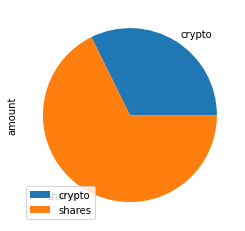

In [123]:
# Plot savings pie chart
df_savings.plot(kind='pie',y='amount')

In [127]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = round(df_savings.amount.sum(),2)
print(total_savings)

# Validate saving health
if total_savings > emergency_fund:
    message = 'Congratulations for having enough money in this fund!!'
elif total_savings == emergency_fund:
    message = 'Congratualtions for meeting your financial goal!'
else:
    message = 'You are $%f away from reaching your savings goal.'%round(emergency_fund - total_savings,2)

print(message)

60002.49
Congratulations for having enough money in this fund!!


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [131]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-01-08', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-01-08', tz='America/New_York').isoformat()

In [133]:
# Get 5 years' worth of historical data for SPY and AGG
tickers = ["AGG","SPY"]
df_stock_data = api.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Display sample data
df_stock_data.tail()

AGG                                          \
                             open      high       low    close     volume   
time                                                                        
2021-01-04 00:00:00-05:00  118.08  118.1400  117.9850  118.040  6211938.0   
2021-01-05 00:00:00-05:00  118.06  118.0600  117.7500  117.915  5915389.0   
2021-01-06 00:00:00-05:00  117.90  117.9000  117.1500  117.360  8587136.0   
2021-01-07 00:00:00-05:00  117.13  117.2600  117.0667  117.210  4949593.0   
2021-01-08 00:00:00-05:00  117.18  117.3428  116.9800  117.090  5580443.0   

                              SPY                                    
                             open    high     low   close    volume  
time                                                                 
2021-01-04 00:00:00-05:00  375.31  375.45  364.82  368.85  92938087  
2021-01-05 00:00:00-05:00  368.10  372.50  368.05  371.32  53668865  
2021-01-06 00:00:00-05:00  369.71  376.98  369.12  373.53  91989131  
2021-01-07 00:00:00-05:00  376.10  379.90  375.91  379.06  58862006  
2021-01-08 00:00:00-05:00  380.59  381.49  377.10  381.24  60275466

In [135]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [136]:
# Printing the simulation input data
MC_thirtyyear.portfolio_data.tail()

AGG                                          \
                             open      high       low    close     volume   
time                                                                        
2021-01-04 00:00:00-05:00  118.08  118.1400  117.9850  118.040  6211938.0   
2021-01-05 00:00:00-05:00  118.06  118.0600  117.7500  117.915  5915389.0   
2021-01-06 00:00:00-05:00  117.90  117.9000  117.1500  117.360  8587136.0   
2021-01-07 00:00:00-05:00  117.13  117.2600  117.0667  117.210  4949593.0   
2021-01-08 00:00:00-05:00  117.18  117.3428  116.9800  117.090  5580443.0   

                                           SPY                          \
                          daily_return    open    high     low   close   
time                                                                     
2021-01-04 00:00:00-05:00    -0.001354  375.31  375.45  364.82  368.85   
2021-01-05 00:00:00-05:00    -0.001059  368.10  372.50  368.05  371.32   
2021-01-06 00:00:00-05:00    -0.004707  369.71  376.98  369.12  373.53   
2021-01-07 00:00:00-05:00    -0.001278  376.10  379.90  375.91  379.06   
2021-01-08 00:00:00-05:00    -0.001024  380.59  381.49  377.10  381.24   

                                                  
                             volume daily_return  
time                                              
2021-01-04 00:00:00-05:00  92938087    -0.013374  
2021-01-05 00:00:00-05:00  53668865     0.006696  
2021-01-06 00:00:00-05:00  91989131     0.005952  
2021-01-07 00:00:00-05:00  58862006     0.014805  
2021-01-08 00:00:00-05:00  60275466     0.005751

In [137]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0          1         2          3          4          5    \
0      1.000000   1.000000  1.000000   1.000000   1.000000   1.000000   
1      1.004774   1.002011  0.999372   0.987995   0.995297   1.013547   
2      1.006608   0.995739  0.991693   0.985681   1.005518   1.023333   
3      1.013477   0.997537  0.997095   0.986455   1.001769   1.031778   
4      1.016996   0.988897  1.001100   0.986236   0.994088   1.015864   
...         ...        ...       ...        ...        ...        ...   
7556  10.194245  37.112934  8.669828  12.980601  13.456507  19.551200   
7557  10.190567  37.193573  8.769074  13.028892  13.494333  19.507494   
7558  10.114481  36.852704  8.683838  13.057652  13.480674  19.658824   
7559  10.123329  37.343283  8.692238  12.985652  13.521151  19.611727   
7560  10.041127  37.845497  8.700737  13.098971  13.534903  19.603497   

            6          7         8          9    ...       490        491  \
0      1.000000   1.000000  1.000000   1.000000  ...  1.000000   1.000000   
1      1.004408   0.995556  1.014892   1.006842  ...  0.998376   1.000071   
2      1.001862   0.995155  1.003021   1.019935  ...  0.997370   1.008862   
3      1.002746   0.986192  1.002672   1.021178  ...  0.999266   1.017100   
4      1.010995   0.980666  0.996996   1.024389  ...  0.993912   1.011445   
...         ...        ...       ...        ...  ...       ...        ...   
7556  30.462720  24.457925  8.256920  17.394369  ...  6.358999  11.631333   
7557  30.746174  24.217931  8.251806  17.540641  ...  6.385122  11.655516   
7558  30.643951  24.379905  8.231673  17.514127  ...  6.309030  11.823087   
7559  30.960316  24.261735  8.081474  17.359517  ...  6.343399  11.838691   
7560  31.045697  24.180674  8.116126  17.340777  ...  6.450879  11.956062   

            492        493        494        495       496        497  \
0      1.000000   1.000000   1.000000   1.000000  1.000000   1.000000   
1      1.007404   1.007850   0.990447   1.002591  1.004212   1.010055   
2      1.010397   1.024833   0.994123   1.006058  1.009835   1.011601   
3      1.003778   1.028416   0.996455   1.009950  1.008002   1.002236   
4      1.005512   1.035745   1.002035   1.002719  1.005354   0.998132   
...         ...        ...        ...        ...       ...        ...   
7556  20.471571  29.868121  17.455476  19.011872  6.438699  21.995004   
7557  20.402766  29.948283  17.318856  18.933421  6.446553  22.175801   
7558  20.755029  29.580241  17.299420  18.880859  6.452516  22.490734   
7559  20.718688  29.739230  17.175062  19.118283  6.453640  22.463279   
7560  20.656130  29.972734  17.088871  19.137996  6.502527  22.493454   

            498        499  
0      1.000000   1.000000  
1      0.999550   0.995081  
2      0.997632   0.991315  
3      1.003326   0.994044  
4      0.999474   0.993469  
...         ...        ...  
7556  25.595594  33.539719  
7557  25.673085  33.800483  
7558  25.580601  33.957898  
7559  25.454226  34.118322  
7560  25.323203  34.517100  

[7561 rows x 500 columns]

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

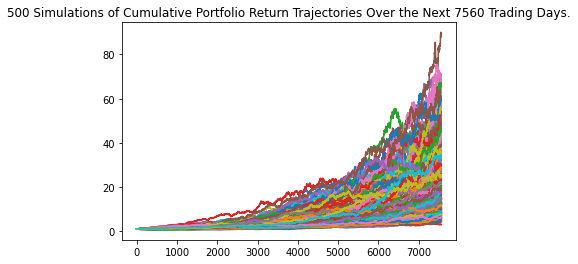

In [138]:
# Plot simulation outcomes
MC_thirtyyear.plot_simulation()

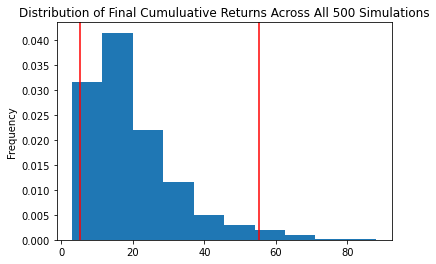

In [139]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirtyyear.plot_distribution()

### Retirement Analysis

In [140]:
# Fetch summary statistics from the Monte Carlo simulation results
mc_statistics = MC_thirtyyear.summarize_cumulative_return()

# Print summary statistics
print(mc_statistics)

count           500.000000
mean             19.978629
std              12.942105
min               3.007328
25%              11.221941
50%              16.331228
75%              24.744571
max              88.045265
95% CI Lower      5.355513
95% CI Upper     55.323022
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the 95% lower and upper confidence intervals based on a `$20,000` initial investment.

In [141]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(mc_statistics[8] * initial_investment,2)
ci_upper = round(mc_statistics[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $107110.26 and $1106460.44


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [142]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(mc_statistics[8] * initial_investment,2)
ci_upper = round(mc_statistics[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $160665.4 and $1659690.66


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [143]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_fiveyear = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.30,.70],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [144]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
mc_fiveyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.009468  0.998550  0.996673  1.001514  1.005549  1.002646  1.009939   
2     1.018465  1.007046  0.990023  1.002956  1.021329  1.005877  1.009348   
3     1.008255  1.002889  0.993169  0.990502  1.012344  1.015670  1.002912   
4     1.018766  1.000279  1.003558  0.998356  1.009211  1.004492  1.008580   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.481740  1.298370  0.881827  1.079876  1.126613  1.786972  1.588426   
1257  1.506645  1.312421  0.879498  1.091996  1.146759  1.770113  1.568723   
1258  1.509468  1.326567  0.878937  1.084872  1.140014  1.776300  1.571040   
1259  1.489012  1.340108  0.886690  1.079366  1.145999  1.781121  1.573075   
1260  1.507388  1.333045  0.889318  1.077337  1.151950  1.770078  1.564824   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.988409  0.989500  0.997264  ...  1.012346  1.006598  1.001077   
2     0.987209  0.979703  1.008497  ...  1.009913  1.000165  0.996102   
3     0.996069  0.995650  1.002756  ...  1.005183  1.002949  0.999143   
4     0.975895  1.000886  1.018037  ...  1.009392  0.993654  1.011100   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.472598  2.349659  1.391768  ...  1.366264  1.719550  1.467830   
1257  1.464446  2.360147  1.414825  ...  1.375943  1.711457  1.448443   
1258  1.454754  2.348450  1.394039  ...  1.373770  1.726532  1.449067   
1259  1.474607  2.351180  1.389361  ...  1.375428  1.728396  1.446849   
1260  1.482672  2.338703  1.368706  ...  1.378820  1.738655  1.443728   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.994358  1.002713  0.995697  1.003419  1.001386  1.003016  1.011997  
2     0.995155  0.995564  1.006226  1.002454  0.997871  1.003791  1.026083  
3     0.994538  1.002428  1.004542  1.010284  0.994759  0.986700  1.019764  
4     0.995410  1.005165  0.999729  0.989649  0.991414  1.002956  1.020721  
...        ...       ...       ...       ...       ...       ...       ...  
1256  1.879383  2.806972  2.480730  2.747299  1.480093  2.138164  2.164122  
1257  1.902715  2.805630  2.460038  2.779979  1.478267  2.146280  2.151387  
1258  1.920407  2.814230  2.468182  2.776905  1.490616  2.152722  2.156348  
1259  1.913409  2.832880  2.491547  2.808905  1.480014  2.156805  2.185141  
1260  1.930017  2.839384  2.481393  2.892751  1.490252  2.140259  2.142545  

[1261 rows x 500 columns]

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

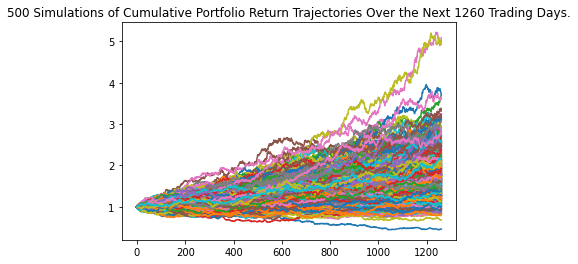

In [145]:
# Plot simulation outcomes
mc_fiveyear.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

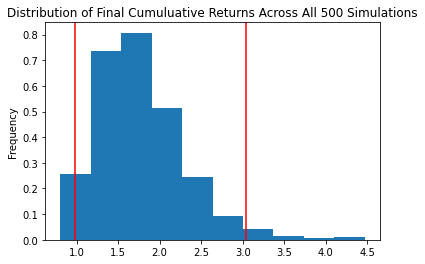

In [147]:
# Plot probability distribution and confidence intervals
mc_fiveyear.plot_distribution()

In [148]:
# Fetch summary statistics from the Monte Carlo simulation results
five_year_portfolio = mc_fiveyear.summarize_cumulative_return()

# Print summary statistics
print(five_year_portfolio)

count           500.000000
mean              1.772964
std               0.532960
min               0.802762
25%               1.397630
50%               1.717063
75%               2.046606
max               4.470395
95% CI Lower      0.976622
95% CI Upper      3.037252
Name: 1260, dtype: float64


In [149]:
# Set initial investment
initial_investment = 60000.00

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(five_year_portfolio[8] * initial_investment,2)
ci_upper_five = round(five_year_portfolio[9] * initial_investment,2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000.0 in the portfolio over the next 5 years will end within in the range of $58597.33 and $182235.12


### Ten Years Retirement Option

In [150]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
mc_ten_year = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.30,.70],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [151]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
mc_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.996872  1.013649  0.981835  1.006439  1.006943  0.986082  1.008970   
2     0.996279  1.007024  0.988919  1.008996  1.005891  0.969679  1.004064   
3     0.992072  0.996882  0.984020  1.005045  0.998648  0.962218  1.004209   
4     0.991065  1.005983  0.975148  1.002734  0.991052  0.957064  1.010439   
...        ...       ...       ...       ...       ...       ...       ...   
2516  4.453623  2.694047  2.012837  3.024948  9.242046  3.944438  5.177243   
2517  4.457693  2.732274  2.020940  3.011049  9.513898  4.000983  5.170831   
2518  4.570019  2.703255  1.994528  3.043256  9.743618  4.043815  5.156777   
2519  4.626665  2.723645  1.951656  3.041982  9.629550  4.070226  5.118690   
2520  4.684939  2.726415  1.923097  3.064725  9.525805  4.021342  5.085675   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.997895  0.998236  0.999410  ...  1.007491  0.985755  1.011110   
2     1.002530  1.008722  1.006441  ...  1.008365  0.986584  1.002730   
3     1.017522  1.014102  1.014485  ...  1.012289  0.982790  1.015261   
4     1.010811  1.013660  1.014052  ...  1.008467  0.988402  1.021666   
...        ...       ...       ...  ...       ...       ...       ...   
2516  5.755257  4.837345  4.688217  ...  3.275993  2.750211  3.954740   
2517  5.770973  4.852023  4.740485  ...  3.219210  2.792187  3.867117   
2518  5.803248  4.849679  4.684337  ...  3.192762  2.784952  3.839171   
2519  5.900389  4.853075  4.691799  ...  3.219871  2.804635  3.852028   
2520  5.843176  4.911634  4.683771  ...  3.244113  2.848362  3.864398   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.981975  1.009512  0.985215  1.005055  1.018874  1.018559  0.981225  
2     0.973738  1.017455  0.972234  1.001829  1.035942  1.024562  0.986253  
3     0.979106  1.027774  0.954591  1.015472  1.034309  1.019118  0.998739  
4     0.972293  1.023601  0.954650  1.006071  1.026511  1.011142  0.995490  
...        ...       ...       ...       ...       ...       ...       ...  
2516  3.847653  2.647049  6.707564  2.012664  2.924879  2.753013  2.860745  
2517  3.834850  2.674283  6.734656  1.974898  2.960350  2.771202  2.885458  
2518  3.854728  2.683521  6.735615  1.962063  2.903933  2.780436  2.919882  
2519  3.863156  2.655513  6.699192  1.956987  2.873806  2.766168  2.922472  
2520  3.840168  2.639543  6.748213  1.945061  2.856958  2.736281  2.917718  

[2521 rows x 500 columns]

<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

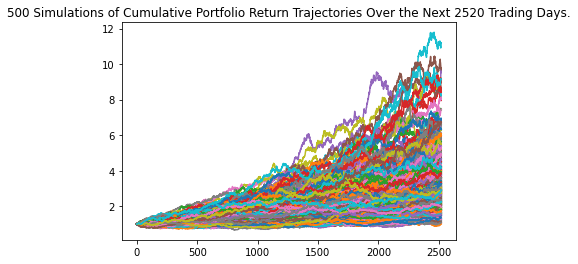

In [152]:
# Plot simulation outcomes
mc_ten_year.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

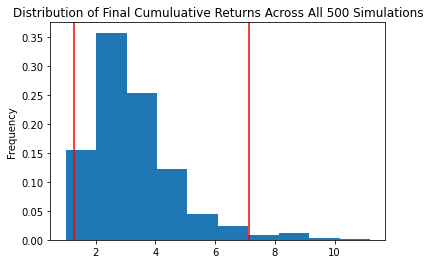

In [153]:
# Plot probability distribution and confidence intervals
mc_ten_year.plot_distribution()

In [155]:
# Fetch summary statistics from the Monte Carlo simulation results
ten_year_portfolio = mc_ten_year.summarize_cumulative_return()

# Print summary statistics
print(ten_year_portfolio)

count           500.000000
mean              3.286129
std               1.484887
min               1.000409
25%               2.255741
50%               2.968762
75%               3.954272
max              11.189059
95% CI Lower      1.280672
95% CI Upper      7.151837
Name: 2520, dtype: float64


In [156]:
# Set initial investment
initial_investment = 60000.00

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(ten_year_portfolio[8] * initial_investment,2)
ci_upper_ten = round(ten_year_portfolio[9] * initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000.0 in the portfolio over the next 10 years will end within in the range of $76840.29 and $429110.2
